---
# Early detection of PSC differentiation


This notebook is related to our publication on [Stem Cells Reports](https://doi.org/10.1016/j.stemcr.2019.02.004). 

The goal was to classify cell colonies in two different states: undifferentiated and on the very early stages of differentiation. 

Naïve mES were plated and 24 hour later differentiation was induced by removing pluripotent stem cell medium. Approximately 60 to 100 images (10x) were randomly taken from each condition in each plate, totaling approximately 300 images per condition. As the images acquire from the microscope are big enough (1240 x 960 pixels) we sliced them into smaller images (640x480). We make sure that each final images contains several PSC colonies based on seeding density.    

---
## Image Slicing
---

We run a python script (image_slicer) on each image in order to get the final size for analysis. 

In [ ]:
import image_slicer
import os

In [ ]:
indir= '/your/path/to/original/images'
outdir= '/your/path/to/sliced/images'

In [ ]:
def split_image_in_four(indir, outdir):
    for root, dirs, filenames in os.walk(indir):
        for file in filenames:
            if file.endswith('.jpg'):
                tiles = image_slicer.slice(os.path.join(indir,file), 4, save=False)
                image_slicer.save_tiles(tiles, 
                                        directory=outdir, 
                                        prefix=file, 
                                        format='jpeg')

In [ ]:
split_image_in_four(indir, outdir)

Microscopy images has this advantage: we can actually get 4 good quality images for analysis (and perhaps more, will try) just from a single one original image, as far as there are enough information in it (for us, enough number of cell colonies).  

## Examples of images after slicing

After slicing, each image includes several cell colonies. Images shown below corresponds to 1 hour after PSC medium was removed. As it can be seen, slight changes can be already seen in the borders (see our pub for a video). Also, colonies spread and on average their size is larger.  

In [19]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

(480, 640, 3)

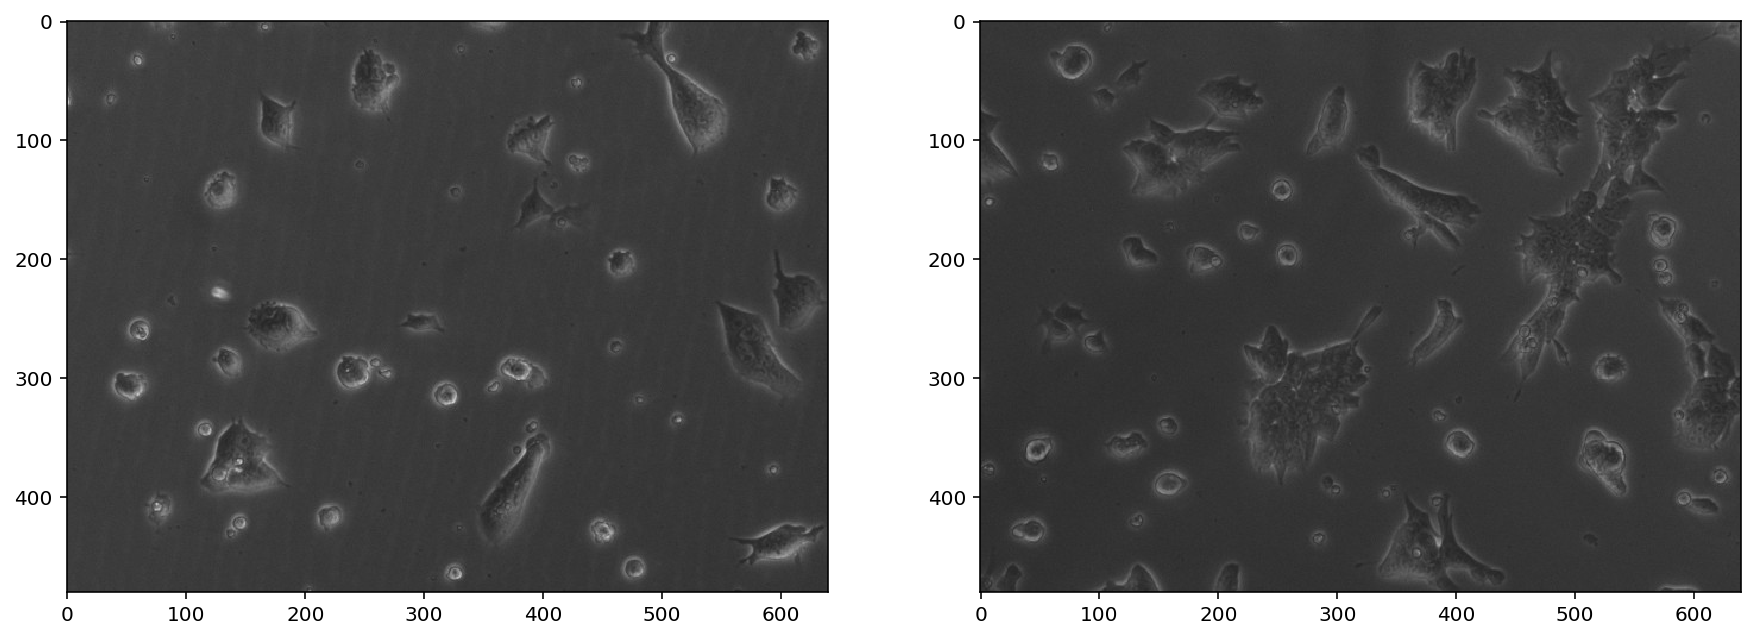

In [20]:
rcParams['figure.figsize'] = 15 ,10

img_A = mpimg.imread('/Users/sgmiriuka/Dropbox/github_paper_DL/n1_t1_indif_234.jpg_01_01.jpg')
img_B = mpimg.imread('/Users/sgmiriuka/Dropbox/github_paper_DL/n1_t1_dif_1.jpg_01_01.jpg')

fig, ax = plt.subplots(1,2)
ax[0].imshow(img_A);
ax[1].imshow(img_B);

img_A.shape

---
# Training model at 1 hour of differentiation
---

We use several different models in our analysis. We found that ResNet50 and DenseNet reacheded the highest accuracies, bith with some image augmentation (just flipping on both sides). 

Models were adapted from [github.com/titu1994](https://github.com/titu1994). In this example, we will use ResNet50 with simple augmentation. 


In [ ]:
setseed=21

In [ ]:
#ResNet model for Keras imported from github.com/titu1994

from __future__ import division
import six
from keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Dense,
    Flatten
)
from keras.layers.convolutional import (
    Conv2D,
    MaxPooling2D,
    AveragePooling2D
)
from keras.layers.merge import add
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K


def _bn_relu(input):
    """Helper to build a BN -> relu block
    """
    norm = BatchNormalization(axis=CHANNEL_AXIS)(input)
    return Activation("relu")(norm)


def _conv_bn_relu(**conv_params):
    """Helper to build a conv -> BN -> relu block
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        conv = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(input)
        return _bn_relu(conv)

    return f


def _bn_relu_conv(**conv_params):
    """Helper to build a BN -> relu -> conv block.
    This is an improved scheme proposed in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    def f(input):
        activation = _bn_relu(input)
        return Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return f


def _shortcut(input, residual):
    """Adds a shortcut between input and residual block and merges them with "sum"
    """
    # Expand channels of shortcut to match residual.
    # Stride appropriately to match residual (width, height)
    # Should be int if network architecture is correctly configured.
    input_shape = K.int_shape(input)
    residual_shape = K.int_shape(residual)
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))
    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]

    shortcut = input
    # 1 X 1 conv if shape is different. Else identity.
    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(input)

    return add([shortcut, residual])


def _residual_block(block_function, filters, repetitions, is_first_layer=False):
    """Builds a residual block with repeating bottleneck blocks.
    """
    def f(input):
        for i in range(repetitions):
            init_strides = (1, 1)
            if i == 0 and not is_first_layer:
                init_strides = (2, 2)
            input = block_function(filters=filters, init_strides=init_strides,
                                   is_first_block_of_first_layer=(is_first_layer and i == 0))(input)
        return input

    return f


def basic_block(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Basic 3 X 3 convolution blocks for use on resnets with layers <= 34.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                           strides=init_strides,
                           padding="same",
                           kernel_initializer="he_normal",
                           kernel_regularizer=l2(1e-4))(input)
        else:
            conv1 = _bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                  strides=init_strides)(input)

        residual = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        return _shortcut(input, residual)

    return f


def bottleneck(filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    """Bottleneck architecture for > 34 layer resnet.
    Follows improved proposed scheme in http://arxiv.org/pdf/1603.05027v2.pdf

    Returns:
        A final conv layer of filters * 4
    """
    def f(input):

        if is_first_block_of_first_layer:
            # don't repeat bn->relu since we just did bn->relu->maxpool
            conv_1_1 = Conv2D(filters=filters, kernel_size=(1, 1),
                              strides=init_strides,
                              padding="same",
                              kernel_initializer="he_normal",
                              kernel_regularizer=l2(1e-4))(input)
        else:
            conv_1_1 = _bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                     strides=init_strides)(input)

        conv_3_3 = _bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv_1_1)
        residual = _bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv_3_3)
        return _shortcut(input, residual)

    return f


def _handle_dim_ordering():
    global ROW_AXIS
    global COL_AXIS
    global CHANNEL_AXIS
    if K.image_dim_ordering() == 'tf':
        ROW_AXIS = 1
        COL_AXIS = 2
        CHANNEL_AXIS = 3
    else:
        CHANNEL_AXIS = 1
        ROW_AXIS = 2
        COL_AXIS = 3


def _get_block(identifier):
    if isinstance(identifier, six.string_types):
        res = globals().get(identifier)
        if not res:
            raise ValueError('Invalid {}'.format(identifier))
        return res
    return identifier


class ResnetBuilder(object):
    @staticmethod
    def build(input_shape, num_outputs, block_fn, repetitions):
        """Builds a custom ResNet like architecture.

        Args:
            input_shape: The input shape in the form (nb_channels, nb_rows, nb_cols)
            num_outputs: The number of outputs at final softmax layer
            block_fn: The block function to use. This is either `basic_block` or `bottleneck`.
                The original paper used basic_block for layers < 50
            repetitions: Number of repetitions of various block units.
                At each block unit, the number of filters are doubled and the input size is halved

        Returns:
            The keras `Model`.
        """
        _handle_dim_ordering()
        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_dim_ordering() == 'tf':
            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        # Load function from str if needed.
        block_fn = _get_block(block_fn)

        input = Input(shape=input_shape)
        conv1 = _conv_bn_relu(filters=64, kernel_size=(7, 7), strides=(2, 2))(input)
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = _residual_block(block_fn, filters=filters, repetitions=r, is_first_layer=(i == 0))(block)
            filters *= 2

        # Last activation
        block = _bn_relu(block)

        # Classifier block
        block_shape = K.int_shape(block)
        pool2 = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1))(block)
        flatten1 = Flatten()(pool2)
        dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model

    @staticmethod
    def build_resnet_18(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [2, 2, 2, 2])

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, basic_block, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(input_shape, num_outputs, bottleneck, [3, 8, 36, 3])


In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
import numpy as np

#Add your path folders for training, validation and test images. 
train_data_dir = '/your/path/to/images/train/'
validation_data_dir = '/your/path/to/images/valid'
test_data_dir = '/your/path/to/images/test'

#We end up with these number if images for training and validation
nb_train_samples = 2034
nb_validation_samples=400


lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=3, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=20)
csv_logger = CSVLogger('/your/path/to/csv/resnet50_1hs_simpleAugmentation.csv')


batch_size = 32
nb_classes = 2
epochs = 200
img_rows, img_cols = 240, 320
img_channels = 3

#Load your datagenerator
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    vertical_flip=True)
valid_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
    

In [ ]:
#Add your generators.    
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = valid_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode='binary')
    
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_rows, imgv_cols),
    batch_size=batch_size,
    class_mode='binary', 
    shuffle = False)
    

### Choose the desired model

In [22]:
    #ResNet34
#model = ResnetBuilder.build_resnet_34((img_channels, img_rows, img_cols), nb_classes)
    #ResNet50
model = ResnetBuilder.build_resnet_50((img_channels, img_rows, img_cols), nb_classes)   
    #ResNet101
#model = ResnetBuilder.build_resnet_101((img_channels, img_rows, img_cols), nb_classes)


### Model fitting


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    shuffle=True,
    verbose=1, 
    max_q_size=100,
    callbacks=[lr_reducer, early_stopper, csv_logger])

---

### Plot Accuracy and Loss figures

Set directories and names.

<Figure size 432x288 with 0 Axes>

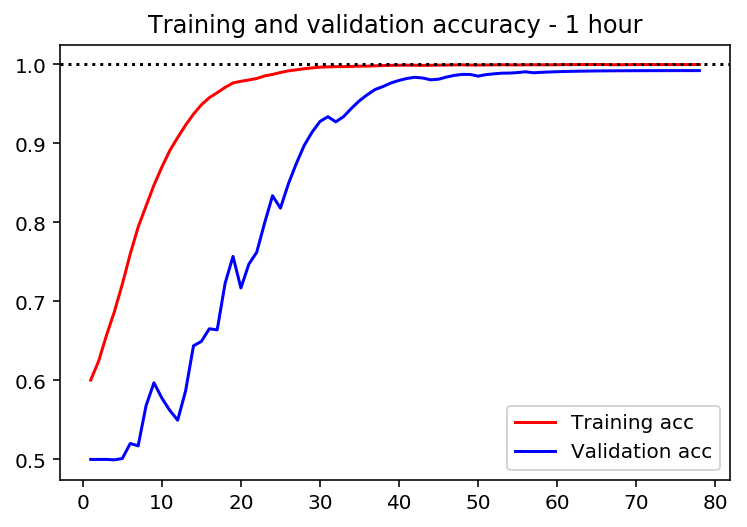

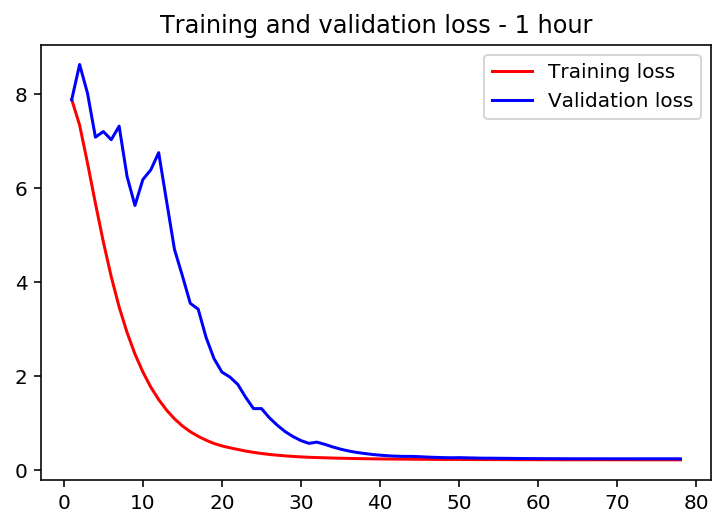

<Figure size 432x288 with 0 Axes>

In [24]:
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs,
         smooth_curve(acc), 'b', label='Training acc', color='red')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Validation acc')
plt.axhline(y=1, ls='dotted', color='k')
plt.title('Training and validation accuracy - 1 hour')
plt.legend()

plt.figure()
plt.plot(epochs,
         smooth_curve(loss), 'b', label='Training loss', color='red')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss - 1 hour')
plt.legend()
plt.figure()



---
### Model Prediction

100 randomly selected images (50 per group) were independently tested on the model.  

In [ ]:
prob = model.predict_generator(test_generator)
#print(prob)
y_pred = np.argmax(prob, axis=1)
print(y_pred)
y_true = test_generator.classes

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

target_names = ['Pluripotent', 'Differentiating']

print(classification_report(y_true, y_pred, target_names=target_names))

In [21]:
cm = confusion_matrix(y_true, y_pred)

In [ ]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
target_names2 = ['PSC', 'Diff']
plt.figure()
plot_confusion_matrix(cm, classes=target_names2, normalize=False,
                      title='Confusion Matrix, 1 hour')
plt.show()